<a href="https://colab.research.google.com/github/FlintyTub49/DL-Sem-VI/blob/main/Experiment%209/Face%20Expression%20Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Packages

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install utils
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
%pwd

Tensorflow version: 2.4.1


'/content'

## Loading Data

In [2]:
def plot_example_images(plt):
    img_size = 48
    plt.figure(0, figsize=(12, 20))
    ctr = 0

    for expression in os.listdir("/content/Project/train/"):
        for i in range(1,6):
            ctr += 1
            plt.subplot(7,5,ctr)
            img = load_img("/content/Project/train/" + expression + "/" +os.listdir("/content/Project/train/" + expression)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")

    plt.tight_layout()
    return plt

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1afmZWHWn6sKs2EyygCwfJ4DvPg2EwhnC' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1afmZWHWn6sKs2EyygCwfJ4DvPg2EwhnC" -O Project.zip && rm -rf /tmp/cookies.txt
!unzip Project.zip

### Showing Images

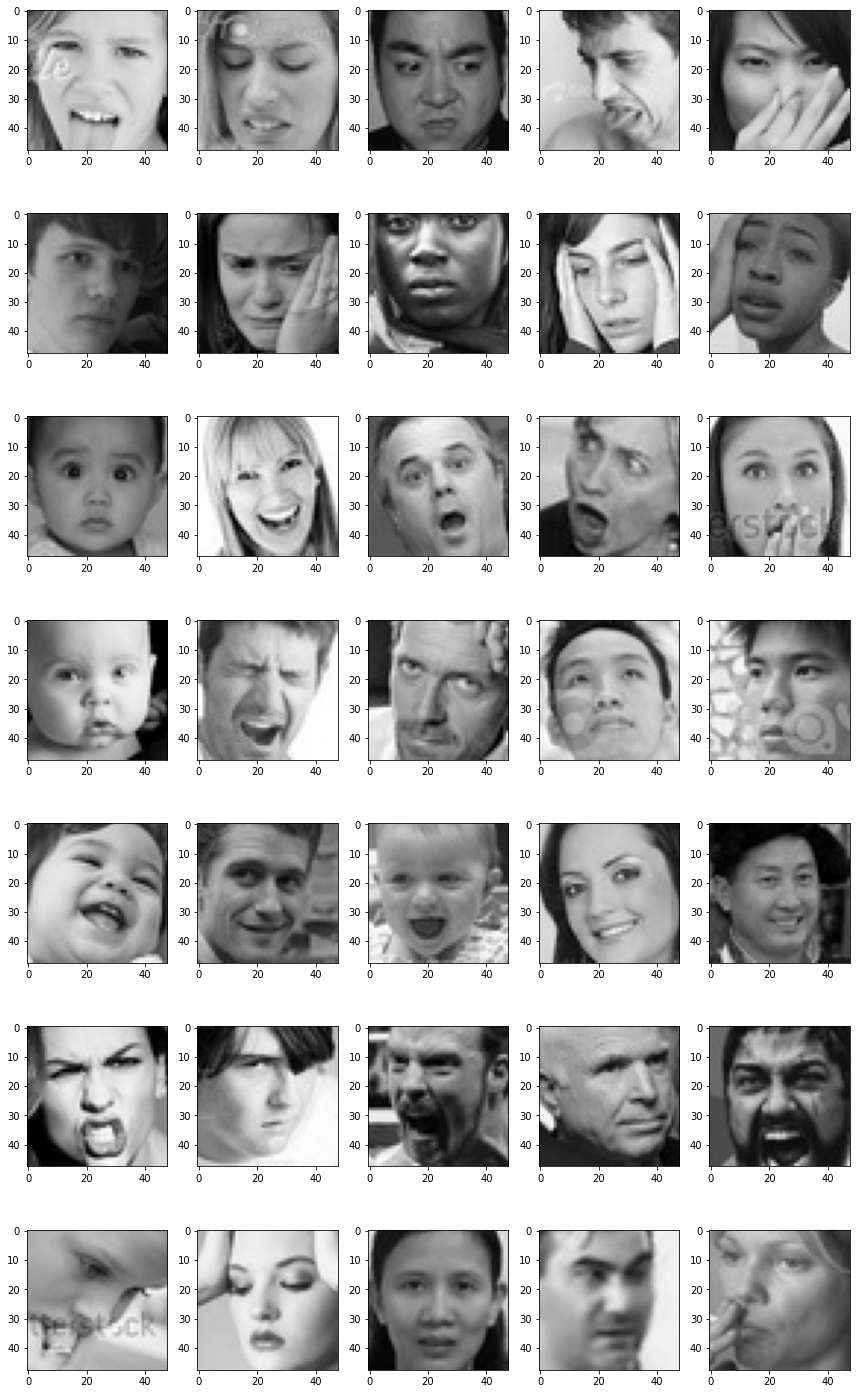

In [4]:
plot_example_images(plt).show()

In [5]:
for expression in os.listdir("/content/Project/train/"):
    print(str(len(os.listdir("/content/Project/train/" + expression))) + " " + expression + " images")

436 disgust images
4830 sad images
3171 surprise images
4965 neutral images
7214 happy images
3995 angry images
4097 fear images


## Performing Image Augmentation

In [6]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip = True)

train_generator = datagen_train.flow_from_directory("/content/Project/train/", target_size = (img_size,img_size), color_mode = "grayscale",
                                                    batch_size = batch_size, class_mode = 'categorical', subset = 'training', shuffle = True)

val_generator = datagen_train.flow_from_directory("/content/Project/train/", target_size = (img_size,img_size), color_mode = "grayscale", 
                                                  batch_size = batch_size, class_mode = 'categorical', subset = 'validation', shuffle = True)

datagen_test = ImageDataGenerator(horizontal_flip = True)

test_generator = datagen_test.flow_from_directory("/content/Project/test/", target_size = (img_size,img_size), color_mode = "grayscale",
                                                  batch_size = batch_size, class_mode = None, shuffle = False)

Found 28708 images belonging to 7 classes.
Found 0 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Making A Model

In [7]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

## Training And Evaluating The Model

In [10]:
%%time

epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = val_generator.n//val_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [checkpoint, reduce_lr]

history = model.fit(x = train_generator, steps_per_epoch = steps_per_epoch, epochs = epochs, 
                    validation_data = val_generator, validation_steps = validation_steps, 
                    callbacks = callbacks)

Epoch 1/15
448/448 [==============================] - 47s 29ms/step - loss: 1.9631 - accuracy: 0.2525

Epoch 00001: saving model to model_weights.h5
Epoch 2/15
448/448 [==============================] - 13s 29ms/step - loss: 1.5438 - accuracy: 0.4091

Epoch 00002: saving model to model_weights.h5
Epoch 3/15
448/448 [==============================] - 13s 29ms/step - loss: 1.3465 - accuracy: 0.4820

Epoch 00003: saving model to model_weights.h5
Epoch 4/15
448/448 [==============================] - 13s 29ms/step - loss: 1.2573 - accuracy: 0.5203

Epoch 00004: saving model to model_weights.h5
Epoch 5/15
448/448 [==============================] - 13s 29ms/step - loss: 1.1966 - accuracy: 0.5425

Epoch 00005: saving model to model_weights.h5
Epoch 6/15
448/448 [==============================] - 13s 29ms/step - loss: 1.1408 - accuracy: 0.5642

Epoch 00006: saving model to model_weights.h5
Epoch 7/15
448/448 [==============================] - 13s 29ms/step - loss: 1.1199 - accuracy: 0.5760

Epo

### Plotting Accuracy and Loss

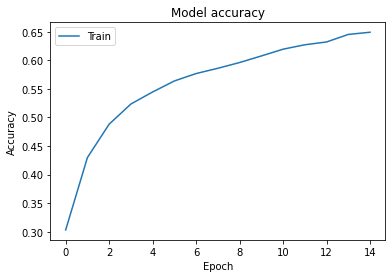

In [12]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

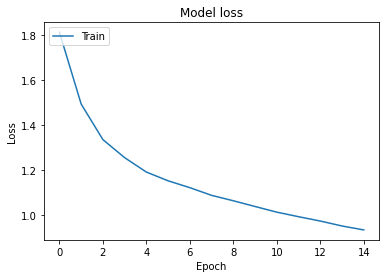

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()